# Goal

The aim of this notebook is to know in deep the current situation of the Irish Real State Market and figure out what are the most promissing variables in order to predict the price.

# Import Libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

import pylab
import scipy.stats as ss
from scipy.stats import kstest
import scipy.stats as stats
from scipy.stats import normaltest

import ppscore as pps
import random
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import (RFE, 
                                       SequentialFeatureSelector)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from daftpy.daftfeanalysis import (missing_values, frequencies, pct_method, 
                                   iqr_method, std_method, outlier_bool, drop_outliers, 
                                  print_limits, 
                                  check_transformations, tchebycheff,
                                  outplots, wrapper_methods, drop_outliers_tmp)
#normality_test, 

from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures, PowerTransformer)

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#plt.style.use('seaborn')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
import warnings

def fxn():
    warnings.warn("user", UserWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
warnings.filterwarnings("ignore")

# Load Data

In [4]:
sale = pd.read_csv('data/sale_post_geosp_fe.csv', sep=',', parse_dates=['entered_renewed', 'scraping_date'])
sale.shape

(7661, 24)

In [5]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7661 entries, 0 to 7660
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   daft_id          7661 non-null   int64         
 1   url              7661 non-null   object        
 2   name             7661 non-null   object        
 3   price            7661 non-null   float64       
 4   sale_type        7661 non-null   object        
 5   floor_area       7661 non-null   int64         
 6   psr              7645 non-null   float64       
 7   ber              7466 non-null   object        
 8   entered_renewed  7661 non-null   datetime64[ns]
 9   views            7661 non-null   float64       
 10  type_house       7174 non-null   object        
 11  type             7661 non-null   object        
 12  scraping_date    7661 non-null   datetime64[ns]
 13  description      7660 non-null   object        
 14  latitude         7661 non-null   float64

Our target or variable response is `price`, whilst the other ones are predictors - variables that we can use to infer the price. Below you can see two tables with each variable, its meaning, and a brief explanation about whether I intuitively consider it is an important predictor or not.

## Data Scraped From Daft.ie

|Variable|Meaning|Importance|Reason|Example|
|:---:|:---:|:---:|:---:|:---:|
|price|House market price|High|It is the target|180000.0|
|daft_id|Ad's id|In-between|It could help us to identify a particular house if we need to|16878701|
|url|Ad's url|In-between|We can visit the ad if we need to|[https://www.daft.ie/for-sale/apartment-5-the-willows-rivercourt-drogheda-co-louth/3608666](https://www.daft.ie/for-sale/apartment-5-the-willows-rivercourt-drogheda-co-louth/3608666)|
|name|Ad's name|Low|Its sctructure is too much heterogeneous and we have coordinates|5 The Willows, Rivercourt, Drogheda, Co. Louth|
|sale_type||Low|Almost all values are the same|For Sale by Private Treaty|
|floor_area|House's floor area|High|High potencial as a predictor|106|
|psr|Advertiser's identifier|Low|It is not an important attribute of the house|2239.0|
|ber|House's energetic efficiency|In-between|No sabe no contesta|B3|
|entered_renewed|Date of entry or renewal of the ad|Low|If an ad has been published for a long time or not is impossible to know because it can have been renewed|2021-11-24 00:00:00|
|views|Number of visits to the ad|In-between|No sabe no contesta|1381.0|
|type_house|Apartment or house|High|It looks like an important attribute|apartment|
|type|Buy or rent|Low|We are analyzing houses for sale, al values are the same|buy|
|scraping_date|Date when ads were scraped|Low|All values are the same|2021-11-25 00:00:00|
|description|Ad's description|In-between||...|
|latitude|House's latitude|High|Provides information about location|53.715574|
|longitude|House's longitude|High|Provides information about location|-6.371515|
|bedroom|Number of bedrooms|High|It looks like an important attribute of a house|2|
|bathroom|Number of bathrooms|High|It looks like an important attribute of a house|2|
|plus_info|More info in a word|Low|I don't know why but it doesn't look like something important|Detached|

## Data From Feature Engineering Methods

|Variable|Meaning|Importance|Reason|Example|
|:---:|:---:|:---:|:---:|:---:|
|postcode|It is the eircode|In-between|I will use the place/code|T23 YE35|
|state_district|State District|Low|It doesn't give too much info|Munster|
|city_district|City District|In-between|Similar to place|Blackpool ED B|
|place |Town or city|High|It's the town|Cork city northside|
|code|Routing key|In-between|I think it would be the same effect than the variable 'place'|T23|

# The Ireland's Real Estate Market

## Introduction

Ireland, also known as the Republic of Ireland, is a country in north-western Europe consisting of 26 of the 32 counties of the island of Ireland. The capital and largest city is Dublin, on the eastern side of the island. Around 40% of the country's population of 5 million people resides in the Greater Dublin Area.

In the next section I will study the current situation of the Irish Real Estate Market hoping to get some insights that helps or guides me in the search of the best predictors and algorithms.

## Current Situation of the Ireland's Real Estate Market

The information and graphs here try to help us to know a little bit the Irish Real Estate Market so we can focus in that areas we think are interesting in our search of potential investment opportunities.

### Ireland's Real Estate Market

#### Advertisements per city

To figure out the number of advertisements per city we need to aggregate those ads with different postal districts from Dublin as they are separed.

In [6]:
# To show some postal districts
sale[['place']].dropna()[sale.place.dropna().str.contains('Dublin')].sample(3)

,place
2337,Dublin 14
4736,Dublin 2
7373,Dublin 3


Something similar happens to Cork city but it has sides instead postal districts.

In [7]:
# To show both side names
pd.DataFrame(sale.place.dropna()[sale.place.dropna().str.contains('Cork')].value_counts()).rename(columns={'place':'freq_abs'})

,freq_abs
Cork city southside,275
Cork city northside,118


So let's build another column changing all those values by `Dublin` or `Cork`. After doing that, we can work with this new column or the another one depending our preferences.

In [8]:
# New column from `place` called `cities`
sale['cities'] = sale.place.copy()

# Index from ads to change
ix_to_change_dublin = sale.cities.dropna()[sale.cities.dropna().str.contains('Dublin')].index
ix_to_change_cork = sale.cities.dropna()[sale.cities.dropna().str.contains('Cork')].index

# Change them
sale.loc[ix_to_change_dublin, 'cities'] = 'Dublin'
sale.loc[ix_to_change_cork, 'cities'] = 'Cork'

Now let's plot a frequency table to see the number of ads per city.

In [9]:
# Frequency table
freq = frequencies(df=sale, variable='cities')
freq.head()

,freq_abs,freq_rel
Dublin,1827,0.24
Cork,393,0.05
Galway,204,0.03
Limerick,180,0.02
Dun Laoghaire,141,0.02


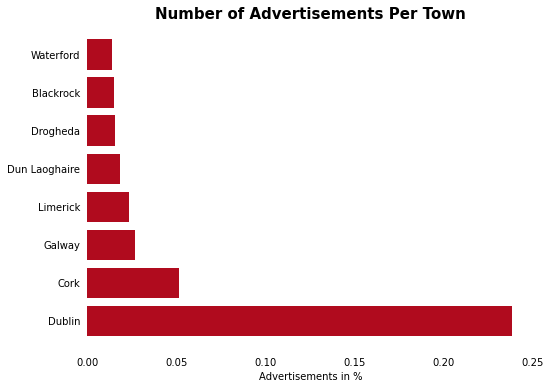

In [10]:
# Filter by cities whose frequency is greater than or equal to 50
freq_50 = freq[freq.freq_abs >= 100].copy()

fig, ax = plt.subplots(figsize=(8,6))

ax.barh(freq_50.index, freq_50.freq_rel, color='#b00b1e')

ax.set_title('Number of Advertisements Per Town', weight='bold', size=15)
ax.set_xlabel('Advertisements in %')

for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)
    
#ax.set_yticks([]) 
ax.tick_params(bottom=False, left=False) 

As we can see Dublin and Cork are the cities with more ads. That is not surprising as they are the bigger ones. We will focus on them later.

#### Mean price per city

In [11]:
# Create new column for square meter prices
sale['m2_price'] = sale.price / sale.floor_area

In [12]:
# Mean price by `cities` sorted in descending order
# and filter by cities with more than 100 ads
mean_price_per_city = pd.pivot_table(data=sale, 
                                        index='cities', 
                                        values=['price', 'm2_price'], 
                                        aggfunc='mean')\
                        .sort_values(by='m2_price', ascending=False)\
                        .loc[freq[freq.freq_abs > 100].index]

# Cities with more than 100 ads
mean_price_per_city

,m2_price,price
Dublin,5113.91,593717.65
Cork,3068.37,355484.61
Galway,2982.44,374845.59
Limerick,2494.81,316372.22
Dun Laoghaire,7046.50,1523296.10
Drogheda,2497.12,301499.58
Blackrock,6224.91,876110.26
Waterford,2222.42,332217.59


Let's plot both mean prices.

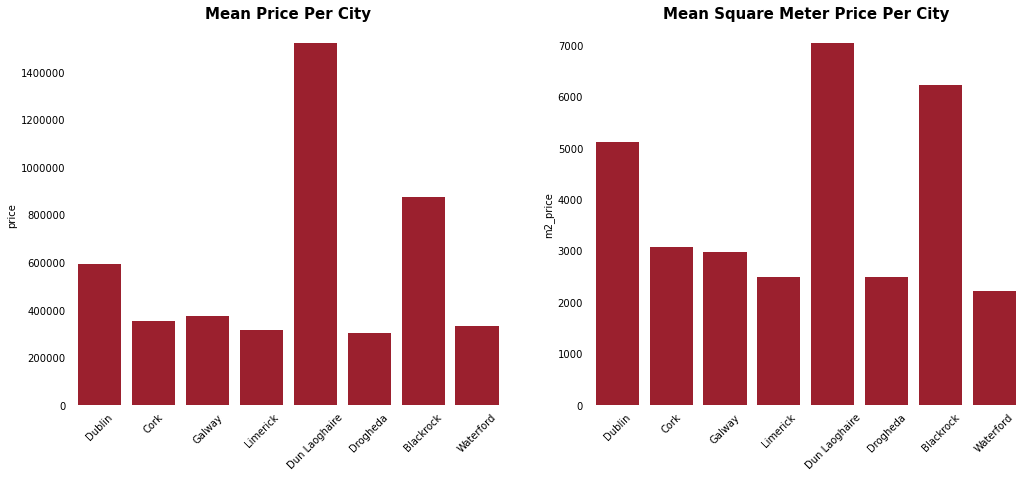

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

axs = sns.barplot(mean_price_per_city.price.index, 
                  mean_price_per_city.price, 
                  ax=axs[0], color='#b00b1e')
axs.set_title('Mean Price Per City', weight='bold', size=15)
axs.ticklabel_format(style='plain', axis='y')
axs.set_xticklabels(mean_price_per_city.price.index, 
                    rotation=45)
for location in ['left', 'bottom', 'right', 'top']:
    axs.spines[location].set_visible(False)
    
axs.tick_params(bottom=False, left=False);


axs = sns.barplot(x=mean_price_per_city.m2_price.index, 
                  y=mean_price_per_city.m2_price, 
                  color='#b00b1e') 
axs.set_title('Mean Square Meter Price Per City', weight='bold', size=15)
axs.ticklabel_format(style='plain', axis='y')
axs.set_xticklabels(mean_price_per_city.m2_price.index, 
                    rotation=45)
for location in ['left', 'bottom', 'right', 'top']:
    axs.spines[location].set_visible(False)
    
axs.tick_params(bottom=False, left=False);

Places with highest prices are Dublin, Laoghaire, and Blackrock. However, Dun Laoghaire and Blackronck belong to Dublin. In this case it has been decided to study them separately.

- Blackrock has `m2_price` pretty similar than Dun Laoghaire but a considerable lower `price`, which means that Blackrock houses are smaller than Dun Laoghaire ones.Something similar happens between Dun Laoghaire and Dublin. 
- Cork y Galway, which are second and third cities by number of unhabitants, have very similar prices.

#### Mean price per city by type_house

In [14]:
# Mean price by `cities` and `type_house`
# and filter by cities with more than 100 ads
mean_price_per_city_by_type_house = pd.pivot_table(data=sale, 
                                                   index=['cities', 'type_house'], 
                                                   values=['price', 'm2_price'], 
                                                   aggfunc='mean')\
                                      .sort_values(by='price', 
                                                   ascending=False)\
                                      .loc[freq[freq.freq_abs > 100].index]\
                                      .unstack()

mean_price_per_city_by_type_house

m2_price             price           
type_house    apartment   house apartment      house
cities                                              
Dublin          5201.67 5086.17 384211.42  699814.24
Cork            3449.26 3009.92 241361.70  374237.88
Galway          3346.30 2834.34 236055.56  417087.25
Limerick        2562.78 2499.21 172586.21  348503.55
Dun Laoghaire   6481.73 7157.72 583698.15 1815234.91
Drogheda        2356.28 2508.97 171702.94  327551.54
Blackrock       6084.17 6299.70 508460.26 1074864.19
Waterford       1970.78 2279.28 133947.37  373687.50

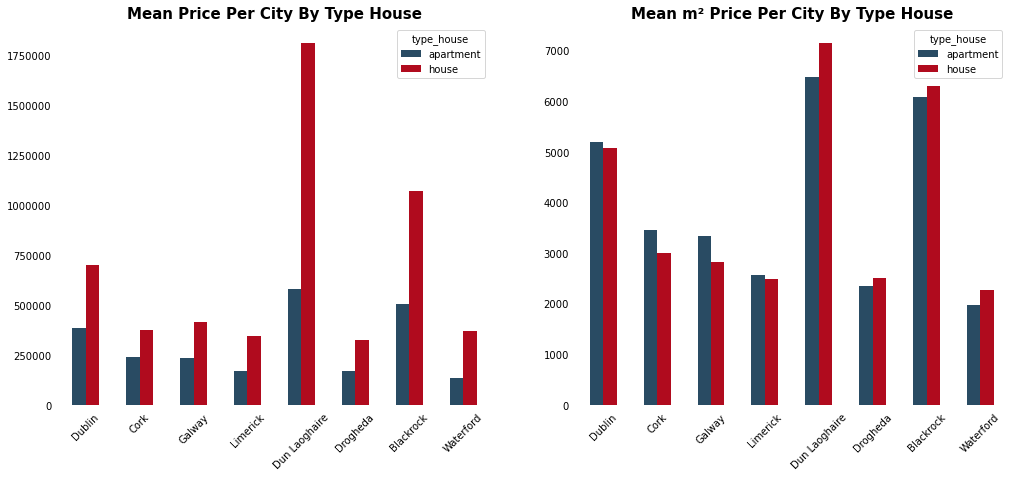

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

mean_price_per_city_by_type_house.price.plot(kind='bar', 
                                             stacked=False, 
                                             ax=ax[0], color=['#294B63', '#b00b1e'])    
ax[0].set_title('Mean Price Per City By Type House', weight='bold', size=15)
ax[0].ticklabel_format(style='plain', axis='y')
ax[0].set_xticklabels(mean_price_per_city_by_type_house.index, rotation=45)
ax[0].tick_params(bottom=False, left=False)
ax[0].set_xlabel('')
for location in ['left', 'bottom', 'right', 'top']:
    ax[0].spines[location].set_visible(False)

mean_price_per_city_by_type_house.m2_price.plot(kind='bar', 
                                                stacked=False, 
                                                ax=ax[1], color=['#294B63', '#b00b1e']);
ax[1].set_title('Mean m² Price Per City By Type House', weight='bold', size=15)
ax[1].set_xticklabels(mean_price_per_city_by_type_house.index, rotation=45)
ax[1].tick_params(bottom=False, left=False)
ax[1].set_xlabel('')
for location in ['left', 'bottom', 'right', 'top']:
    ax[1].spines[location].set_visible(False)

- `m2_price` is pretty similar between apartmets and houses in Dublin, Dun Laoghaire, and Blackrock. However, houses prices are more expensive in the three places than apartment prices which means that houses tend to be bigger than apartments. 
- In Cork, as in Dublin, the apartments square meter prices are a little bigger than apartments ones but houses are more expensives. That means that the same patter happens there. 

### Dublin's Real Estate Market

We will need postal district's data if we want to dig a little into Dublin's Real Estate Market.

#### House Mean Price Per Postal District

In [16]:
# Filter to take Dublin related information
sale_dublin = sale.dropna(subset=['place']).loc[(sale.place.dropna().str.contains('Dublin'))
                                                | (sale.place == 'Blackrock')
                                                | (sale.place == 'Dun Laoghaire')]
sale_dublin.shape

(2085, 26)

In [17]:
# Mean price by `place`
mean_price_dublin_by_postal_districts = pd.pivot_table(data=sale_dublin, 
                                                       index='place', 
                                                       values=['price', 'm2_price'], 
                                                       aggfunc='mean')\
                                          .sort_values(by='price', 
                                                       ascending=False)

mean_price_dublin_by_postal_districts.head(5)

,m2_price,price
place,,
Dun Laoghaire,7046.50,1523296.10
Dublin 6,6859.80,1174651.58
Dublin 4,7393.07,1019543.21
Blackrock,6224.91,876110.26
Dublin 2,6666.84,834261.90


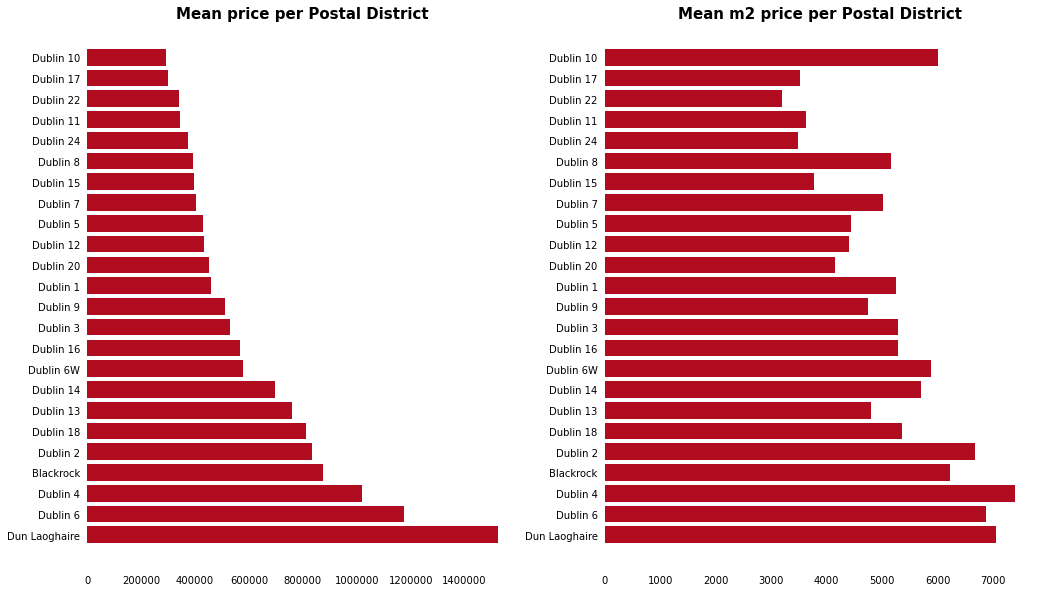

In [18]:
data = mean_price_dublin_by_postal_districts

fig, ax = plt.subplots(1, 2, figsize=(17, 10))

ax[0].barh(data.index, data.price, data=data, color='#b00b1e')
ax[0].set_title('Mean price per Postal District', weight='bold', size=15)
ax[0].ticklabel_format(style='plain', axis='x')
ax[0].tick_params(bottom=False, left=False)
for location in ['left', 'bottom', 'right', 'top']:
    ax[0].spines[location].set_visible(False)

ax[1].barh(data.index, data.m2_price, data=data, color='#b00b1e') 
ax[1].set_title('Mean m2 price per Postal District', weight='bold', size=15)
ax[1].ticklabel_format(style='plain', axis='x')
ax[1].tick_params(bottom=False, left=False)
for location in ['left', 'bottom', 'right', 'top']:
    ax[1].spines[location].set_visible(False)

As we see in the left graph the more expensive districts are Dun Laoghaire, Dublin 6, and Dublin 4. One thing that catch my attention is Dublin 10. Their houses prices are the cheapest ones but their square meter mean price is 6.000€! Despite having low sale prices they are actually pretty expensive.

#### House Mean Price Per Postal District And Type House

In [19]:
# Mean price by `place` and `type_house`
mean_price_dublin_by_postal_district_and_type_house = pd.pivot_table(data=sale_dublin, 
                                                                     index=['place', 'type_house'], 
                                                                     values=['price', 'm2_price'], 
                                                                     aggfunc='mean')\
                                                        .sort_values(by='price', 
                                                                     ascending=False)\
                                                        .unstack()

mean_price_dublin_by_postal_district_and_type_house.head()

m2_price             price           
type_house apartment   house apartment      house
place                                            
Blackrock    6084.17 6299.70 508460.26 1074864.19
Dublin 1     5550.61 4782.34 451165.91  483447.96
Dublin 10    3627.45 6355.89 185000.00  294000.00
Dublin 11    3432.50 3734.97 212661.11  382877.03
Dublin 12    3922.84 4384.43 273368.75  445923.53

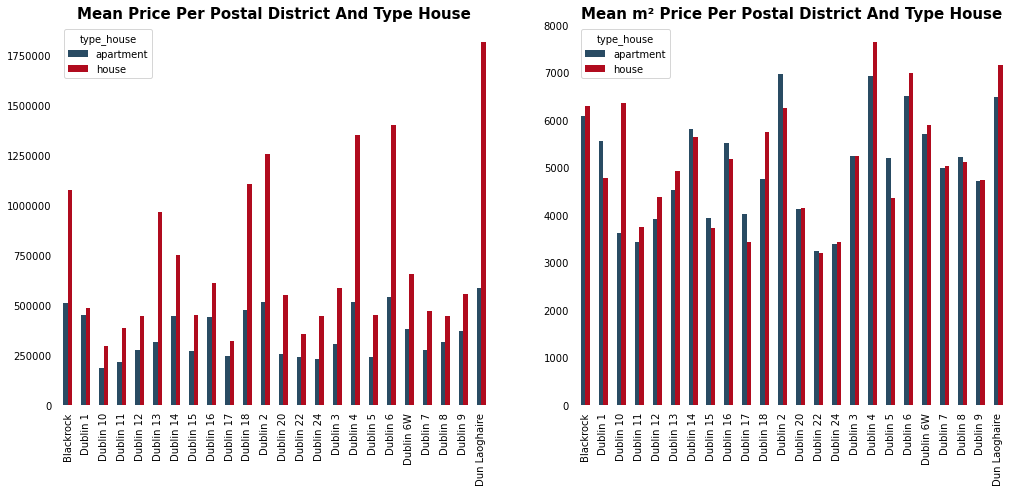

In [20]:
data = mean_price_dublin_by_postal_district_and_type_house

fig, ax = plt.subplots(1, 2, figsize=(17, 7))

data.plot(y='price', kind='bar', stacked=False, ax=ax[0], color=['#294B63', '#b00b1e'])
ax[0].set_title('Mean Price Per Postal District And Type House', weight='bold', size=15)
ax[0].ticklabel_format(style='plain', axis='y')
ax[0].tick_params(bottom=False, left=False)
ax[0].set_xlabel('')
for location in ['left', 'bottom', 'right', 'top']:
    ax[0].spines[location].set_visible(False)

data.plot(y='m2_price', kind='bar', stacked=False, ax=ax[1], color=['#294B63', '#b00b1e'])
ax[1].set_title('Mean m² Price Per Postal District And Type House', weight='bold', size=15)
ax[1].tick_params(bottom=False, left=False)
ax[1].set_xlabel('')
for location in ['left', 'bottom', 'right', 'top']:
    ax[1].spines[location].set_visible(False)

House total prices are higher than apartment ones but their mean square meter price are similar so that confirm our thouth about houses size. The `type_house` variable should be a good price predictor. 

#### Floor Area Per Postal District And Type House

In [21]:
# Mean floor area by `place` and `type_house`
mean_floor_area_dublin_by_postal_district = pd.pivot_table(data=sale_dublin, 
                                                           index=['place', 'type_house'], 
                                                           values='floor_area', 
                                                           aggfunc='mean')\
                                              .sort_values(by='floor_area', 
                                                           ascending=False)\
                                              .unstack()

mean_floor_area_dublin_by_postal_district.head()

floor_area       
type_house  apartment  house
place                       
Blackrock       86.23 171.95
Dublin 1        83.35 101.51
Dublin 10       51.00  86.27
Dublin 11       62.78 128.05
Dublin 12       72.12 103.66

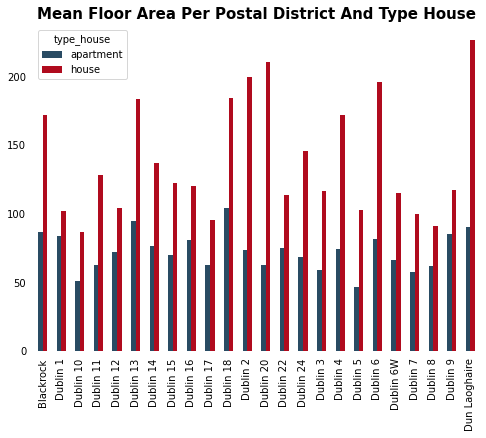

In [22]:
fig, ax = plt.subplots(figsize=(8,6))

mean_floor_area_dublin_by_postal_district.plot(y='floor_area', kind='bar', stacked=False, 
                                               ax=ax, color=['#294B63', '#b00b1e'])
ax.set_title('Mean Floor Area Per Postal District And Type House', weight='bold', size=15)
ax.tick_params(bottom=False, left=False)
ax.set_xlabel('')
for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)

As we deduced earlier Dublin 10 has really small houses.

`type_house` and `floor_area` should both be good predictors but they may be correlated so they could proxy each other. 

### Cork's Real Estate Market

#### Mean price per side

In [23]:
# Filter to take Cork related information
sale_cork = sale.dropna(subset=['place']).loc[(sale.place.dropna().str.contains('Cork'))]
sale_cork.shape

(393, 26)

In [24]:
# Mean price by `place`
mean_price_cork_by_side = pd.pivot_table(data=sale_cork, 
                                         index='place', 
                                         values=['price', 'm2_price'], 
                                         aggfunc='mean')\
                            .sort_values(by='price', 
                                         ascending=False)

mean_price_cork_by_side

,m2_price,price
place,,
Cork city southside,3213.33,371049.09
Cork city northside,2730.56,319211.44


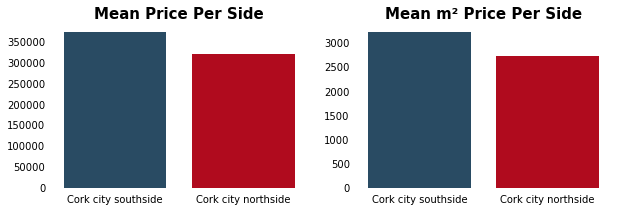

In [25]:
data = mean_price_cork_by_side

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].bar(data.index, data.price, data=data, color=['#294B63', '#b00b1e'])
ax[0].set_title('Mean Price Per Side', weight='bold', size=15)
ax[0].tick_params(bottom=False, left=False)
for location in ['left', 'bottom', 'right', 'top']:
    ax[0].spines[location].set_visible(False)

ax[1].bar(data.index, data.m2_price, data=data, color=['#294B63', '#b00b1e'])
ax[1].set_title('Mean m² Price Per Side', weight='bold', size=15)
ax[1].tick_params(bottom=False, left=False)
for location in ['left', 'bottom', 'right', 'top']:
    ax[1].spines[location].set_visible(False)

#### Mean price per side and type_house

In [26]:
# Mean price by `place` and `type_house`
mean_price_cork_by_side_and_type_house = pd.pivot_table(data=sale_cork, 
                                                        index=['place', 'type_house'], 
                                                        values=['price', 'm2_price'], 
                                                        aggfunc='mean')\
                                            .sort_values(by='m2_price', 
                                                         ascending=False)\
                                            #.unstack()

mean_price_cork_by_side_and_type_house

m2_price     price
place               type_house                    
Cork city southside apartment    3640.19 258216.22
                    house        3148.82 391041.85
Cork city northside apartment    2742.81 179000.00
                    house        2703.80 337203.88

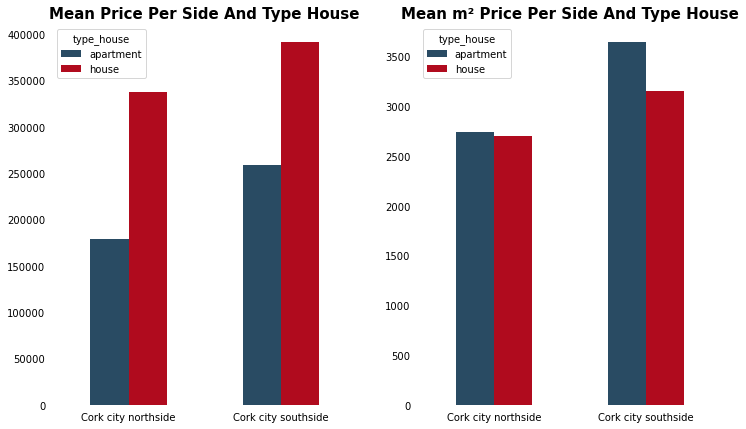

In [27]:
data = mean_price_cork_by_side_and_type_house.unstack()

fig, ax = plt.subplots(1, 2, figsize=(12, 7))

data.plot(y='price', kind='bar', stacked=False, ax=ax[0], color=['#294B63', '#b00b1e'])
ax[0].set_title('Mean Price Per Side And Type House', weight='bold', size=15)
ax[0].set_xticklabels(data.index, rotation=0)
ax[0].tick_params(bottom=False, left=False)
ax[0].set_xlabel('')
for location in ['left', 'bottom', 'right', 'top']:
    ax[0].spines[location].set_visible(False)


data.plot(y='m2_price', kind='bar', stacked=False, ax=ax[1], color=['#294B63', '#b00b1e'])
ax[1].set_title('Mean m² Price Per Side And Type House', weight='bold', size=15)
ax[1].set_xticklabels(data.index, rotation=0)
ax[1].tick_params(bottom=False, left=False)
ax[1].set_xlabel('')
for location in ['left', 'bottom', 'right', 'top']:
    ax[1].spines[location].set_visible(False)

Cork prices are much smaller than Dublin ones. As expected their prices follow the same pattern as Dublin where houses are more expensive due to the floor area meanly.

#### Mean floor area per postal district and type_house

In [28]:
# Mean floor area by `place` and `type_house`
mean_floor_area_cork_by_side = pd.pivot_table(data=sale_cork, 
                                              index=['place', 'type_house'], 
                                              values='floor_area', aggfunc='mean')\
                                 .sort_values(by='floor_area', 
                                              ascending=False)\
                                 .unstack()

mean_floor_area_cork_by_side

floor_area       
type_house           apartment  house
place                                
Cork city northside      67.00 173.44
Cork city southside      74.51 133.51

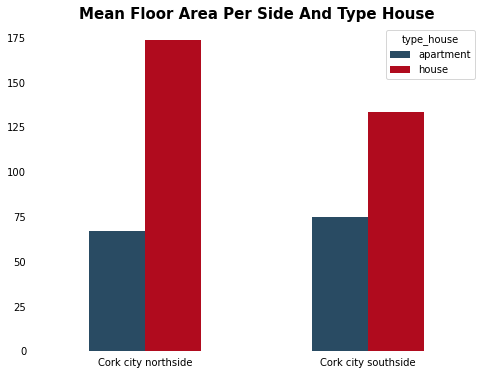

In [29]:
fig, ax = plt.subplots(figsize=(8,6))

mean_floor_area_cork_by_side.plot(y='floor_area', kind='bar', stacked=False, 
                                  ax=ax, color=['#294B63', '#b00b1e'])
ax.set_title('Mean Floor Area Per Side And Type House', weight='bold', size=15)
ax.set_xticklabels(mean_floor_area_cork_by_side.index, rotation=0)
ax.tick_params(bottom=False, left=False)
ax.set_xlabel('')
for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)

# Distributions

## Numeric Variables

The graphs below show the distribution of each numeric variable. We can see that most of them are heavy skewed to the right and have a lot of outliers. It is normal to happen when the variable is capped at zero on the lower size. Also, a house do not usually have 10000 square meters and 40 bathrooms so it is possible to have some commercial properties ads in the data set. As we are working on a regression problem we should remove those outliers as they can distort the results and predictive power of the models. 

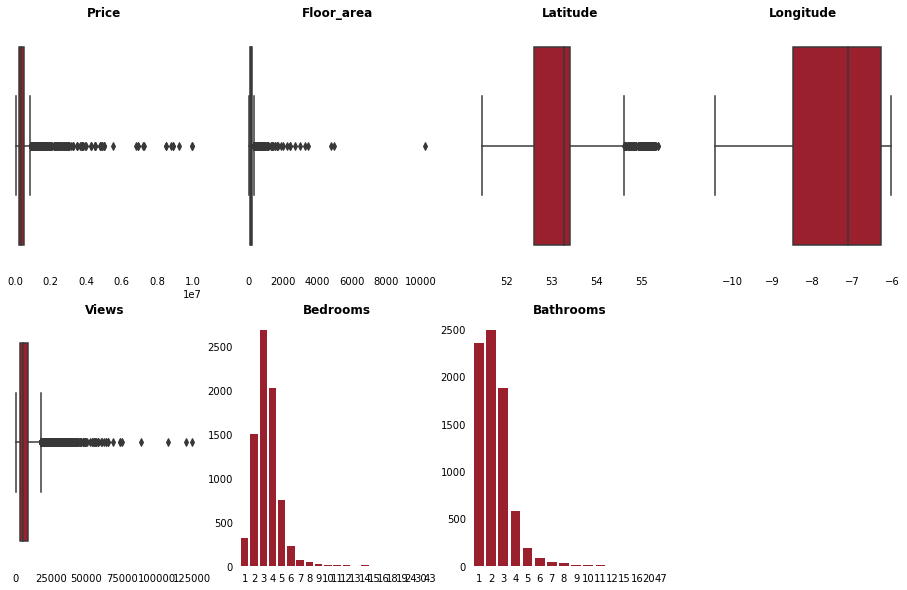

In [30]:
fig, ax = plt.subplots(2, 4, figsize=(16, 10))

features = ['price', 'floor_area', 'latitude', 'longitude', 'views', 'bedroom', 'bathroom']

i = 0
row = 0
column = 0

for feature in features:
    if i == 4:
        row = 1
        column = 0
    
    if (feature != 'bedroom') and (feature != 'bathroom'):
        sns.boxplot(data=sale[feature], x=sale[feature], 
                    ax=ax[row, column], color='#b00b1e')
        ax[row, column].set_title(f'{feature.capitalize()}', weight='bold')
        ax[row, column].set_xlabel('')
        ax[row, column].tick_params(bottom=False, left=False)
    else:
        sns.barplot(x=sale[feature].value_counts().index, 
                    y=sale[feature].value_counts().values, 
                    ax=ax[row, column], color='#b00b1e')
        ax[row, column].set_title(f'{feature.capitalize()}s', weight='bold')
        ax[row, column].tick_params(bottom=False, left=False)
    for location in ['left', 'bottom', 'right', 'top']:
        ax[row, column].spines[location].set_visible(False)
        
    i += 1
    column += 1

for location in ['left', 'bottom', 'right', 'top']:
    ax[1, 3].spines[location].set_visible(False)
#ax[1, 3].set_xticklabels('')
#ax[1, 3].set_yticklabels('')
ax[1, 3].set_xticks([])
ax[1, 3].set_yticks([]);

Before dropping any outlier let's calculate the skewness and Tchebycheff bounds in order to be able to check the result of the variable's transformation after dropping them. We are going to use k = 2 so there will be a 75% of probabilities that an ads is between both limits.

In [31]:
numeric_features = ['price', 'floor_area', 'views', 
                    'bedroom', 'bathroom', 'latitude', 
                    'longitude']

tchebycheff(df=sale, 
            num_features=numeric_features, 
            k=2)

k = 2 -> 75.0%


,skewness,kurtosis,lim_inf,lim_sup
price,8.03,97.46,-647768.94,1517692.33
floor_area,24.55,1025.70,-246.86,543.48
views,4.11,31.74,-8030.83,22316.47
bedroom,5.19,90.01,0.36,6.43
bathroom,5.85,126.57,-0.61,5.22
latitude,-0.02,0.14,51.62,54.54
longitude,-0.44,-1.23,-9.80,-5.06


### Outliers Detection and Elimination

We will consider a value as an outlier only when it is detecting for each one of the following methods.

**Percentile-Based Method**
- The percentile method cuts off a predefined percentage amount from the top and the bottom of a distribution (if both sides are desired). 

**Interquartile Range Method**
- The interquartile range approach first calculates the interquartile range of the data and then this range is multiplied with 1.5. Any data that is then further away than any of the limits calculated is classified as an outlier.

Before drop any value let's see how many outliers are detected in each variable and what are the resulting bounds.

#### Detecting `price` Outliers

In [32]:
print_limits(sale, 'price')

Percentile based method: [79000.0, 2650000.0]
Interquartile range method: [-155000.0, 845000.0]


In [33]:
no_out_price, outliers_price = drop_outliers_tmp(sale, 'price', continuous=True)

Range before: [32000.0, 10000000.0]

Limits: [-155000.0, 2650000.0]
No outliers: 7587
Outliers: 74

Range after: [2700000.0, 10000000.0]
Outliers dropped: 7587


#### Detecting `floor_area` Outliers

In [34]:
print_limits(sale, 'floor_area')

Percentile based method: [40.0, 628.1999999999971]
Interquartile range method: [-43.0, 293.0]


In [35]:
no_out_farea, outliers_farea = drop_outliers_tmp(sale, 'floor_area', continuous=True)

Range before: [1, 10279]

Limits: [40.0, 628.1999999999971]
No outliers: 7513
Outliers: 148

Range after: [1, 10279]
Outliers dropped: 7513


#### Detecting `views` Outliers

In [36]:
print_limits(sale, 'views')

Percentile based method: [329.4000000000001, 37978.59999999989]
Interquartile range method: [-6010.5, 17481.5]


In [37]:
no_out_views, outliers_views = drop_outliers_tmp(sale, 'views', continuous=True)

Range before: [0.0, 125030.0]

Limits: [-6010.5, 37978.59999999989]
No outliers: 7584
Outliers: 77

Range after: [38161.0, 125030.0]
Outliers dropped: 7584


#### Detecting `bedroom` Outliers

In [38]:
print_limits(sale, 'bedroom')

Percentile based method: [1.0, 8.0]
Interquartile range method: [1.5, 5.5]


In [39]:
no_out_bedroom, outliers_bedroom = drop_outliers_tmp(sale, 'bedroom', continuous=True)

Range before: [1, 43]

Limits: [1.0, 8.0]
No outliers: 7608
Outliers: 53

Range after: [9, 43]
Outliers dropped: 7608


#### Detecting `bathroom` Outliers

In [40]:
print_limits(sale, 'bathroom')

Percentile based method: [1.0, 7.0]
Interquartile range method: [-2.0, 6.0]


In [41]:
no_out_bathroom, outliers_bathroom = drop_outliers_tmp(sale, 'bathroom', continuous=True)

Range before: [1, 47]

Limits: [-2.0, 7.0]
No outliers: 7594
Outliers: 67

Range after: [8, 47]
Outliers dropped: 7594


#### Dropping Outliers

Once we have detected the outliers we can use their index to drop them.

In [42]:
sale_out = drop_outliers(df=sale)

PRICE
Range before: [32000.0, 10000000.0]

Limits: [-155000.0, 2650000.0]
No outliers: 7587
Outliers: 74

Range after: [32000.0, 10000000.0]
Outliers to drop: 74
-----------
FLOOR_AREA
Range before: [1, 10279]

Limits: [40.0, 628.1999999999971]
No outliers: 7513
Outliers: 148

Range after: [1, 10279]
Outliers to drop: 148
-----------
VIEWS
Range before: [0.0, 125030.0]

Limits: [-6010.5, 37978.59999999989]
No outliers: 7584
Outliers: 77

Range after: [0.0, 125030.0]
Outliers to drop: 77
-----------
BEDROOM
Range before: [1, 43]

Limits: [1, 8.0]
No outliers: 7608
Outliers: 53

Range after: [1, 43]
Outliers to drop: 53
-----------
BATHROOM
Range before: [1, 47]

Limits: [1, 7.0]
No outliers: 7594
Outliers: 67

Range after: [1, 47]
Outliers to drop: 67
-----------
---------------
Shape before: (7661, 26)
Shape after: (7344, 26)
Outliers dropped: 317


And if we check the skewness and the Tchebycheff bounds we will see that skewness and kurtosis have reduced a lot and the bounds are closer to each other. 

The statistics of skewness and kurtosis can be used to detect desviations from normality. A kurtosis and coefficient of asymmetry values between -1 and 1 is generally considered a weak desviation from normality (Bulmer, 1979), (Brown, n.d.). One between -2 and 2 would be an evident desviation from normality but not extreme. [cienciadelosdatos.net](https://www.cienciadedatos.net/documentos/pystats06-analisis-normalidad-python.html)

In [43]:
tchebycheff(df=sale_out, num_features=numeric_features, k=2)

k = 2 -> 75.0%


,skewness,kurtosis,lim_inf,lim_sup
price,3.10,13.78,-206768.68,982658.68
floor_area,1.91,5.16,-16.24,281.75
views,2.06,5.47,-4767.06,17825.83
bedroom,0.51,0.72,1.01,5.59
bathroom,1.00,1.38,-0.01,4.42
latitude,-0.02,0.14,51.63,54.54
longitude,-0.43,-1.23,-9.79,-5.07


### Checking Outliers Elimination Results

Now let's dig a little deeper to check the results of those outliers elimination and how the distributions are afected by that and other transformation like Logarithmic or Coxbox transformations.

**The Cutoff Levels**

||Price|floor Area|Views|Bedroom|Bathroom|
|:---:|:---:|:---:|:---:|:---:|:---:|
|**Minimum**|32000.00|1|0.00|1|1|
|**Cutoff Min**|32000.00|40|0.00|1|1|
|**Cutoff Max**|2650000.00|732|46044.00|8|7|
|**Maximun**|10000000.00|10279|125030.00|43|47|

After dropping outliers the cutoff levels appear much more reasonable.

We are going to plot every variable whit histograms (bar plots for discrete ones) and probability plots. The dangerous zone (red area) is where the outliers are, it has been colored to see more easily the effect of the transformations.

#### Price Outliers Elimination Results

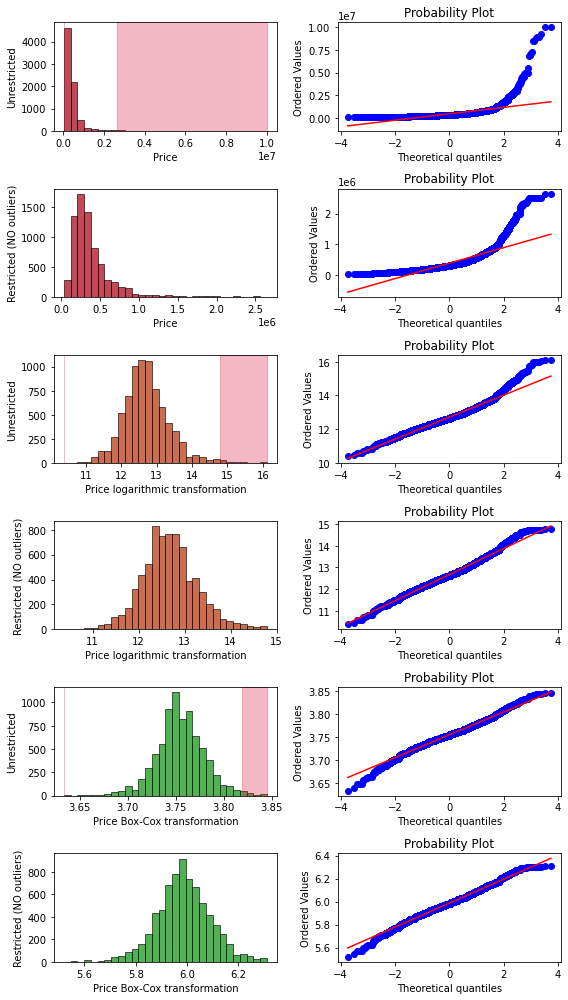

In [44]:
check_transformations('price', sale, sale_out)

#### Floor Area Outliers Elimination Results

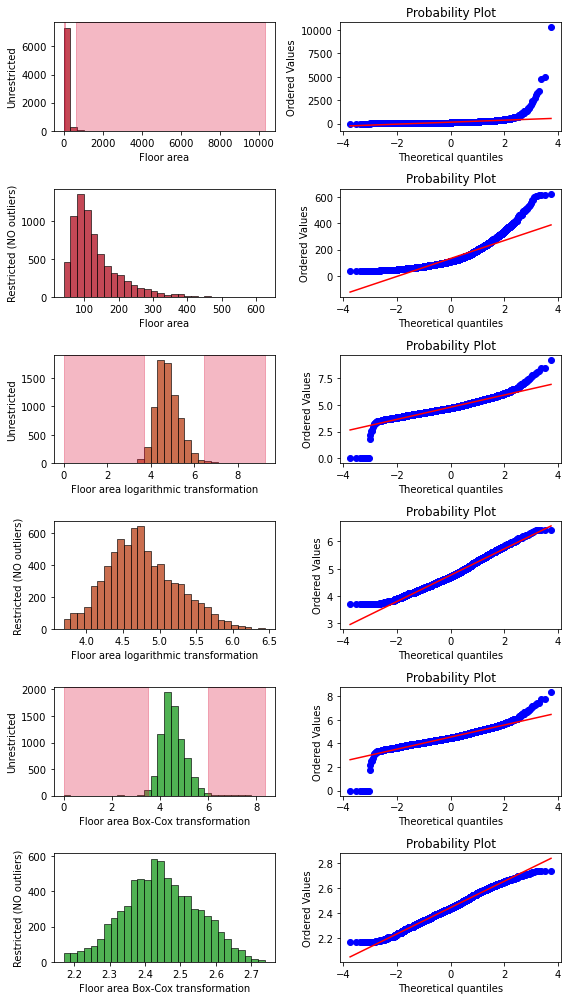

In [45]:
check_transformations('floor_area', sale, sale_out)

#### Views Outliers Elimination Results

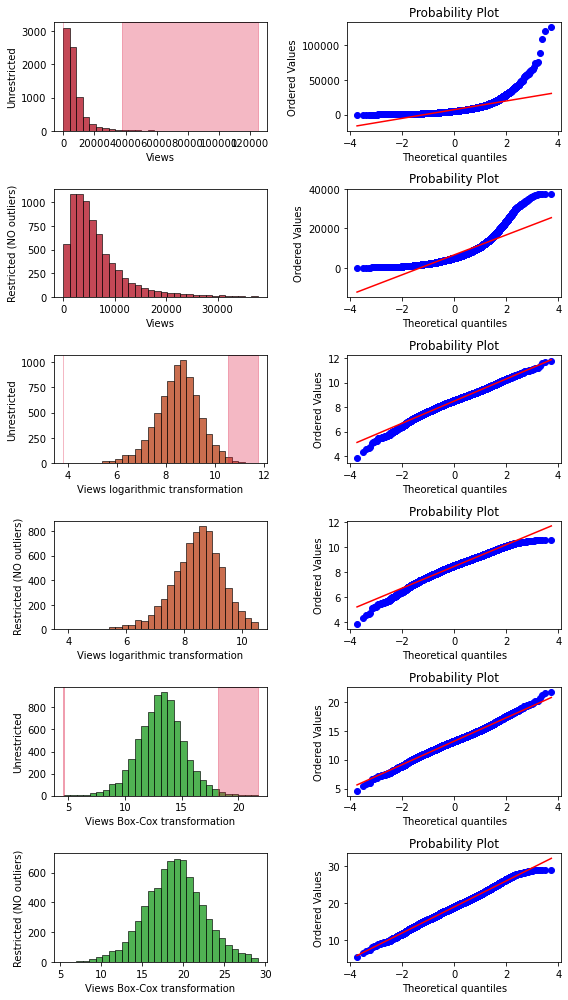

In [46]:
check_transformations('views', 
                      sale.loc[sale['views']!=0].copy(), 
                      sale_out.loc[sale_out['views']!=0].copy())

#### Bedroom Outliers Elimination Results

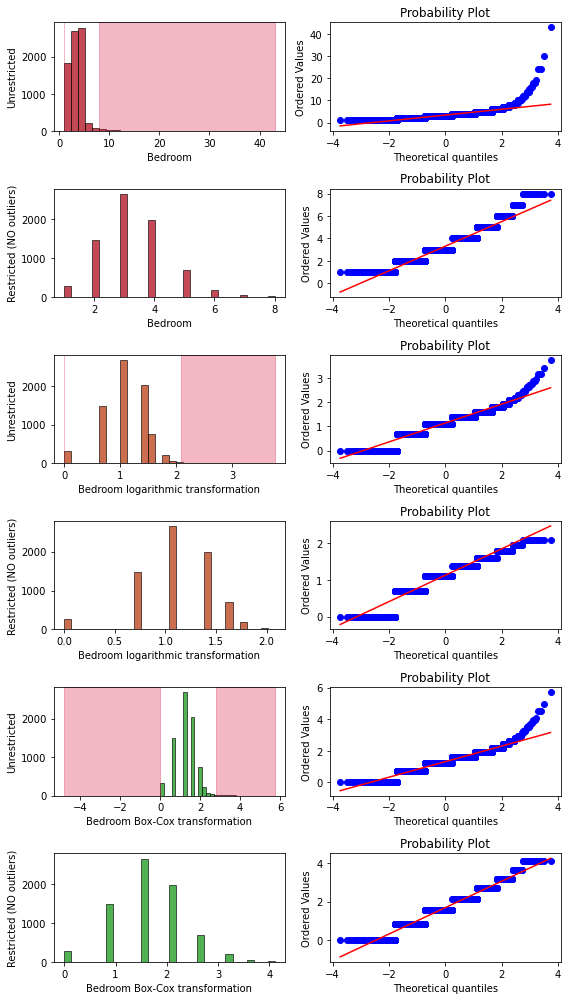

In [47]:
check_transformations('bedroom', sale, sale_out)

#### Bathroom Outliers Elimination Results

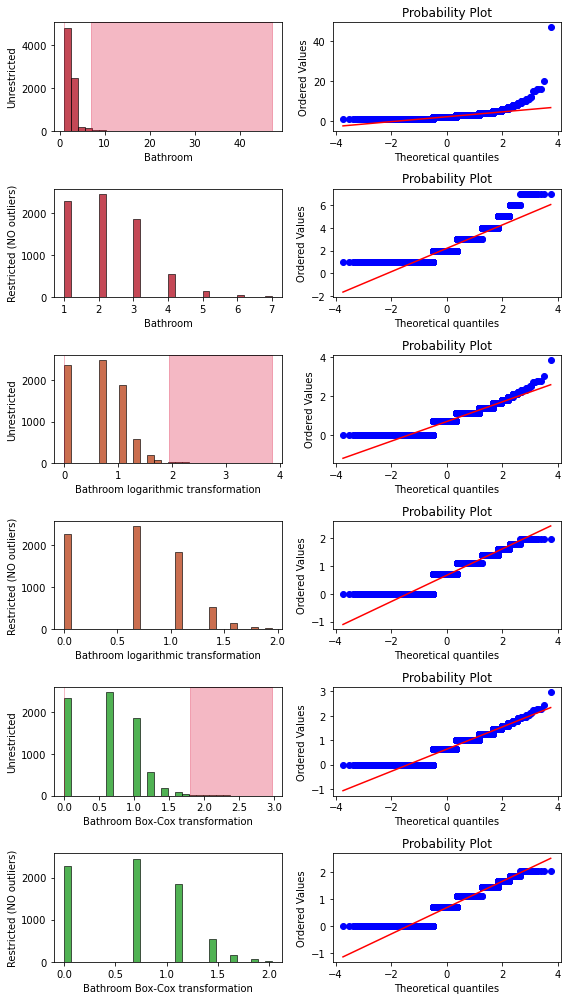

In [48]:
check_transformations('bathroom', sale, sale_out)

### Conclusions

As we have seen, the elimination of outliers and a few kind of transformations can help us to reduce the skewness and obtain something closer to a Gaussian distribution. As will use several algorithms which are built on the assumption of normality in the distribution of the data so I will use it in most of cases. 

In [49]:
tchebycheff(df=sale, num_features=numeric_features, k=2)

k = 2 -> 75.0%


,skewness,kurtosis,lim_inf,lim_sup
price,8.03,97.46,-647768.94,1517692.33
floor_area,24.55,1025.70,-246.86,543.48
views,4.11,31.74,-8030.83,22316.47
bedroom,5.19,90.01,0.36,6.43
bathroom,5.85,126.57,-0.61,5.22
latitude,-0.02,0.14,51.62,54.54
longitude,-0.44,-1.23,-9.80,-5.06


In [50]:
tchebycheff(df=sale_out, num_features=numeric_features, k=2)

k = 2 -> 75.0%


,skewness,kurtosis,lim_inf,lim_sup
price,3.10,13.78,-206768.68,982658.68
floor_area,1.91,5.16,-16.24,281.75
views,2.06,5.47,-4767.06,17825.83
bedroom,0.51,0.72,1.01,5.59
bathroom,1.00,1.38,-0.01,4.42
latitude,-0.02,0.14,51.63,54.54
longitude,-0.43,-1.23,-9.79,-5.07


## Categorical Variables

We will need to transform the categorical data before to show it to the algorithms so let's explore it.

### Type House

Below you can see the houses and apartments frequencies. There are much more ads of houses than of apartments.

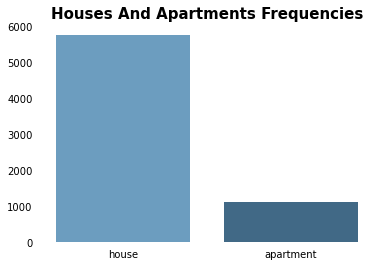

In [51]:
fig, ax = plt.subplots(figsize=(6,4))

sns.countplot(data=sale_out, x='type_house', palette="Blues_d", ax=ax)
ax.set_title('Houses And Apartments Frequencies', weight='bold', size=15)

for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)
    
ax.tick_params(bottom=False, left=False) 
ax.set_xlabel('')
ax.set_ylabel('');

Houses and apartments have similar squared meter prices but houses tend to be more expensive and I conclud that is because the houses' floor area is bigger. The imagen bellow shows the distributions of houses and apartments prices.

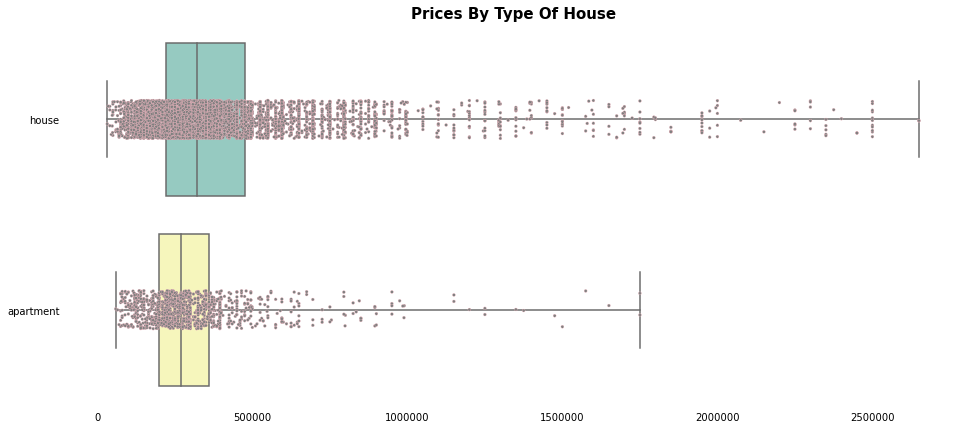

In [52]:
fig, ax = plt.subplots(figsize=(16, 7))

ax = sns.boxplot(data=sale_out, x='price', y='type_house', orient='h', 
                 order=['house', 'apartment'],
                 whis=np.inf, palette="Set3")

ax = sns.stripplot(data=sale_out, x='price', y='type_house' ,orient='h', 
                   order=['house', 'apartment'],
                   color="gray", edgecolor="pink", linewidth=.3,  size=3)

ax.set_title('Prices By Type Of House', weight='bold', size=15)
ax.ticklabel_format(style='plain', axis='x')

for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)
    
ax.tick_params(bottom=False, left=False) 
ax.set_xlabel('')
ax.set_ylabel('');

### Ber

A Building Energy Rating (BER) certificate rates your home's energy performance on a scale between A and G. A-rated homes are the most energy efficient while G-rated are the least energy efficient. [Sustainable Energy Authority of Ireland](https://www.seai.ie/home-energy/building-energy-rating-ber/)

I have my doubs about the utility of this variable as a predictor for the price but maybe it could be correlated with the age of the house, been the newest houses more energy efficient. But that is just a thinking and I can not check it with the current available data.

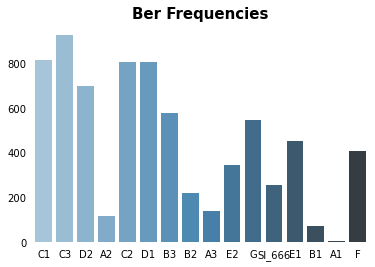

In [53]:
fig, ax = plt.subplots(figsize=(6,4))

sns.countplot(data=sale_out, x='ber', palette="Blues_d", ax=ax)
ax.set_title('Ber Frequencies', weight='bold', size=15)

for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)
    
ax.tick_params(bottom=False, left=False) 
ax.set_xlabel('')
ax.set_ylabel('');

In [54]:
# sale_out.ber.value_counts()

### Plus Info

Plus info doesn't seem any useful at all. Maybe is a little useful in order to predict houses prices but I don't need it is to predict apartments prices as practically all apartments that show this information have the value `Apartment`.

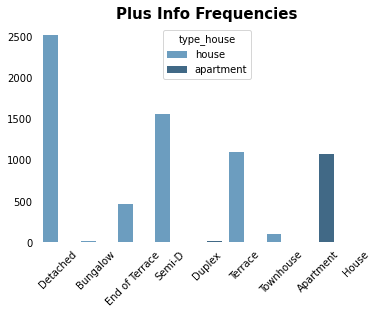

In [55]:
fig, ax = plt.subplots(figsize=(6,4))

sns.countplot(data=sale_out, x='plus_info', palette="Blues_d", hue='type_house', ax=ax)
ax.set_title('Plus Info Frequencies', weight='bold', size=15)

for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)

ax.set_xticklabels(sale_out.plus_info.unique(), rotation=45)
ax.tick_params(bottom=False, left=False) 
ax.set_xlabel('')
ax.set_ylabel('');

In [56]:
# sale.plus_info.value_counts()

### Place

This variable has been explored earlier. It seems to be a great predictor.

In [57]:
sale_out.place.value_counts().sort_values(ascending=False).head()

Cork city southside    268
Galway                 195
Limerick               176
Dublin 4               140
Dublin 8               139
Name: place, dtype: int64

### Postcode and Code

`postcode` has a potentilly similar effect than code as the code is the routing key of the eircode. The postcode/eircode has also the unique identifier. I think that something that identify every house or apartment individually like the unique identidier can not be a good predictor if we want that our model can generalize well. I think that using the postcode as a predictor, thus using the unique identifier, is exactly the same as whether the `daft_id` identifier was used. It doesn't make sense for me.

In [58]:
# sale_out.postcode.value_counts()  

In [59]:
# sale_out.code.value_counts() 

`code` and `place` should have the same efect in the models as there is a place for each code/routing key. So we will use only one of them in the model.

### State District

In [60]:
sale_out.state_district.value_counts()

Leinster    4001
Munster     1998
Connacht     961
Name: state_district, dtype: int64

Intuitively I don't think this variable will have a big inpact in the model performance but let's explore it more in the "Relationships and Feature Selection" section. I think that this variable does not contribute anything that the `place` variable can not contribute.

### City District

`city_district` could have a little more potential as a predictor than `state_district` as it specifies the location. However, I have available the coordinates as well so I think that work could be done by them. I will study better all the variables as predictors in the nex section.

In [61]:
sale_out.city_district.value_counts().head()  

Ballincollig - Carrigaline    126
Clondalkin ED                  60
Stillorgan ED                  57
Blanchardstown ED              49
Glencullen ED                  46
Name: city_district, dtype: int64

# Relationships and Feature Selection

## Scatter Plots

I will use scatter plots in order to figure out relationships between variables. Scatter plots can help us visualizate linear relationships as well as nonlinear ones. 

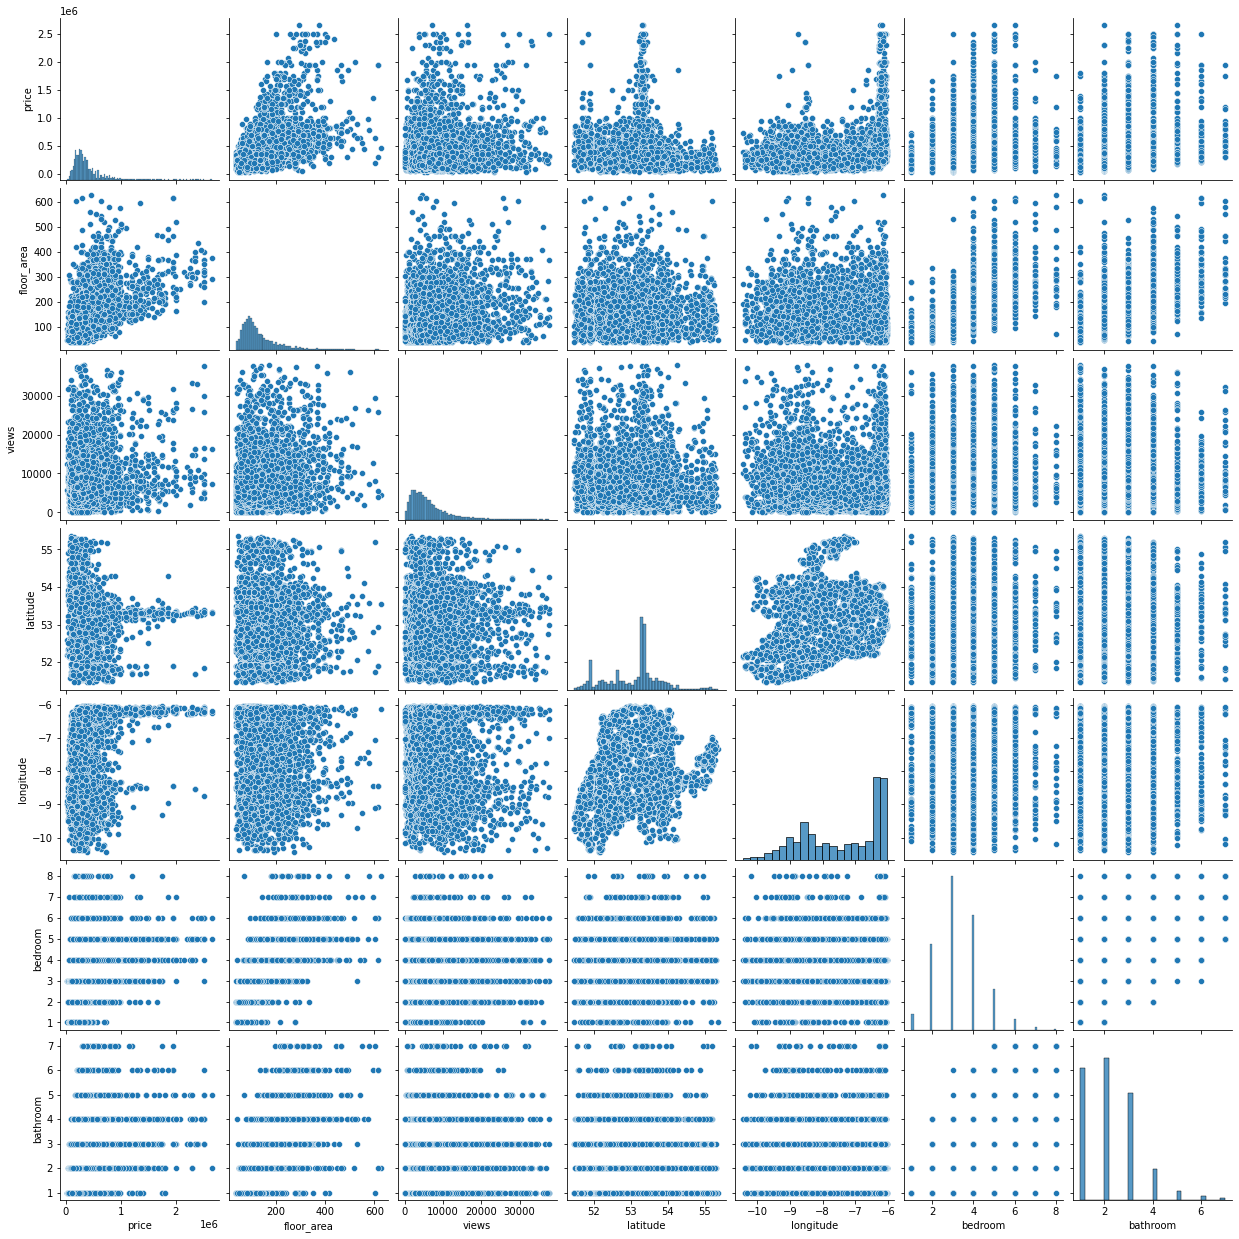

In [62]:
variables = ['price', 
             'floor_area', 
             'views', 
             'latitude', 
             'longitude', 
             'bedroom', 
             'bathroom',  
            # 'm2_price',
            ]

sns.pairplot(sale_out[variables],
             kind= 'scatter'
            );

It is difficult to see any relationship in most cases but there are a few ones:
- It seems to be an increasing linear relationships between `price` and `floor_area`.
- `bedroom` and `bathroom` seem to have a mild relationships with `price` and maybe a little stronger one with `floor_area`.
- `latitude` and `longitude` both show two rare patterns where `price` increases around two differents coordinates values. Actually these patterns have a logical explanation. The longitude with higher prices matches with Dublin and the other one that stands out from the rest matches with Cork and Galway, as both have similar coordinates. Something similar happens in the latitude plot. Dublin and Galway have similar latitudes and Cork is in the south. We can see this if we look a map as the scatter plot between `latitude` and `longitude` and compare it with the other plots.

## Correlations

Now let's see what correlation coefficients have to say. We are going to plot a heatmap for the Pearson correlation coefficient and another one for the Spearman's one. But first let's remember them.

Pearson vs Spearman:

- The Pearson correlation coefficient is a statistic that measures the linear correlation between two variables. This statistic can evaluate only a linear relationship between two continuous variables (proportional change).
- The Spearman's rank correlation coefficient is a nonparametric measure of [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation). This statistic can evaluate a [monotonic](https://es.wikipedia.org/wiki/Funci%C3%B3n_mon%C3%B3tona) relatinship between two variables - continuous or ordinal.

Differences:
- Pearson coefficient works with linear relationships whereas Spearman coefficient works with monotonic relationships as well.
- Pearson works with raw data values of the variable whereas Spearman works with rank-ordered variables.

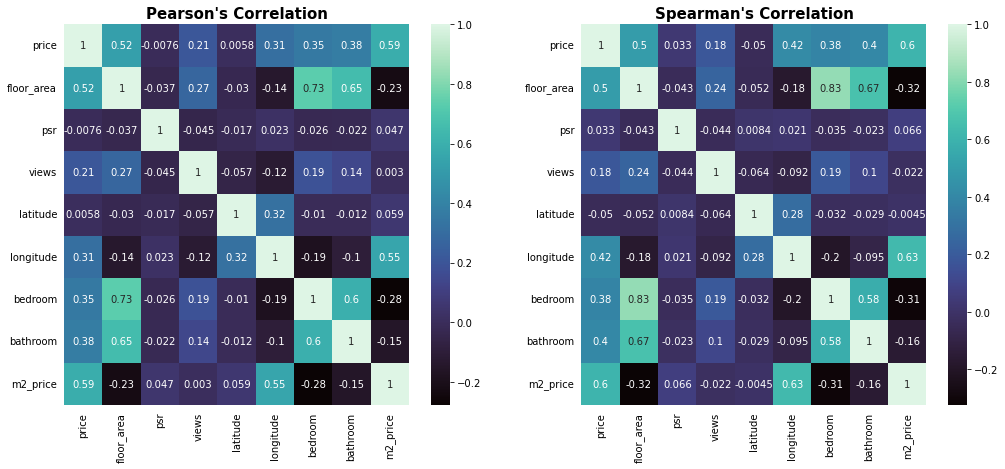

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

sns.heatmap(sale_out.drop(columns=['daft_id']).corr(method='pearson'), 
            annot=True, cmap='mako', ax=ax[0])
ax[0].set_title("Pearson's Correlation", weight='bold', size=15)
ax[0].tick_params(bottom=False, left=False)

sns.heatmap(sale_out.drop(columns=['daft_id']).corr(method='spearman'), 
            annot=True, cmap='mako', ax=ax[1])
ax[1].set_title("Spearman's Correlation", weight='bold', size=15)
ax[1].tick_params(bottom=False, left=False)

Conclusions:

- As we concluded from the scatter plots there is a linear relationships between `price` and `floor_area`. 
- `longitude`, `bedroom`, and `bathroom` show interesting relationships with the `price`. We can note how `bedroom` and `bathroom` are also correlated with `floor_area`, which makes sense.
- There are no strong decreasing relationships between variables.

I conclude that it would be good looking for more data in order to find more variables with predictive capabilities.

## Predictive Power Score

Predictive Power Score is a kind of score that is asymmetric and data-type agnostic and helps in identifying linear and non-linear relationships between two variables. We can figure out how useful a variable would be in predicting the values of another one.

- PPS lies between 0 (no predictive power) and 1 (highest predictive power).
- PPS let us handle not only numerical variables (as correlation) but also other kinds of values namely categoric, nominal, etc.
- PPS can find out non-linear relationships among different variables whic cannot be obtained from correlation.
- Correlation matrix is symmetrical, which can give a misleading interpretation that the correlation of column A to B is and B to A is the same. PPS is asymmetric, which means that if column A can predict column B values, it does not mean that column B can also predict column A.

More information about PPS:

- [ppscore - a Python implementation of the Predictive Power Score (PPS)](https://github.com/8080labs/ppscore)
- [Introducing the Predictive Power Score (PPS)](https://docs.bamboolib.8080labs.com/documentation/reference/predictors#introducing-the-predictive-power-score-pps)
- [RIP correlation. Introducing the Predictive Power Score](https://medium.com/towards-data-science/rip-correlation-introducing-the-predictive-power-score-3d90808b9598)
- [What is Predictive Power Score (PPS) – Is it better than Correlation ?](https://machinelearningknowledge.ai/predictive-power-score-vs-correlation-with-python-implementation/)

**Regression**

In case of a regression, the ppscore uses the mean absolute error (MAE) as the underlying evaluation metric (MAE_model). The best possible score of the MAE is 0 and higher is worse. As a baseline score, we calculate the MAE of a naive model (MAE_naive) that always predicts the median of the target column. The PPS is the result of the following normalization (and never smaller than 0):

> PPS = 1 - (MAE_model / MAE_naive)

In [64]:
variables = ['price', 'sale_type', 'floor_area', 'psr', 
             'ber', 'views', 'type_house',
             'latitude', 'longitude', 'bedroom',
             'bathroom', 'plus_info', 'postcode', 
             'state_district', 'city_district',
             'place', 'code', 'cities']

# You can see the resulted DataFrame with the following line of code
pps.predictors(sale_out[variables], 'price', output='df', sorted=True).head()

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,city_district,price,0.13,regression,True,mean absolute error,175275.57,153107.57,DecisionTreeRegressor()
1,code,price,0.13,regression,True,mean absolute error,187654.28,164067.52,DecisionTreeRegressor()
2,place,price,0.13,regression,True,mean absolute error,187654.28,164068.04,DecisionTreeRegressor()
3,postcode,price,0.11,regression,True,mean absolute error,185639.27,165471.20,DecisionTreeRegressor()
4,psr,price,0.08,regression,True,mean absolute error,175601.72,162287.31,DecisionTreeRegressor()


Text(113.09375, 0.5, '')

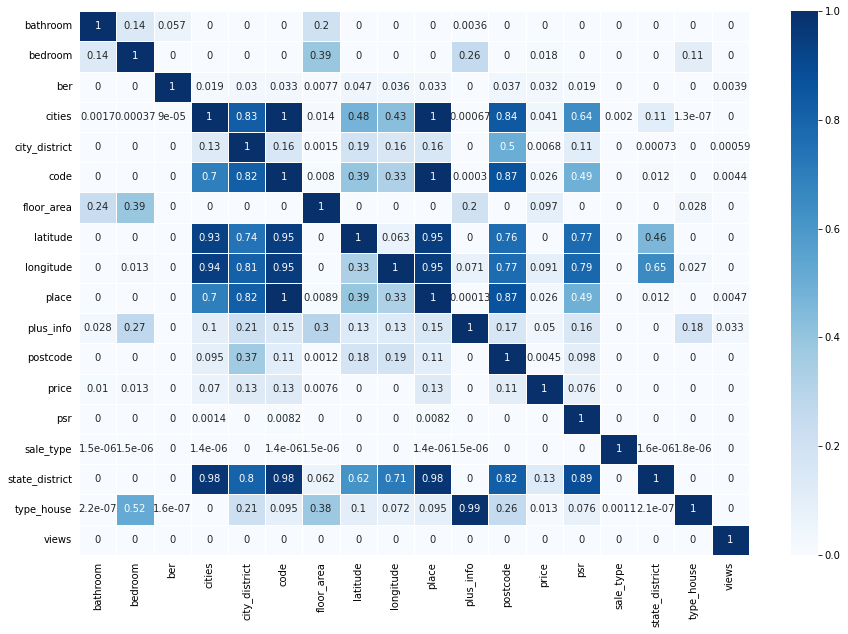

In [65]:
fig, ax = plt.subplots(figsize=(15, 10))
                               
matrix_df = pps.matrix(sale_out[variables])[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, ax=ax)
ax.tick_params(bottom=False, left=False)
ax.set_xlabel('')
ax.set_ylabel('')

The PPS matrix shows a slow predictive power to predict the `price` with the other variables. This is a bit disappointing. However, let's be possitive and focus in learning what we can from the results.

- `city_district`, `code`, `place`, and `postcode` have some predictive power to the `price`. If we pay attention we can realize that all of them are **location** variables, which makes sense. Moreover, `code` and `place` are exactly the same but with different characters as place was extracted from `code` just exchanging the Eircode for the corresponding city or town.
- `cities` has some predictive power but is the same that `place` without differenciating Dublin postal districts.
- `psr` has some predictive power and it also makes sense because the psr identify the seller. It is normal to think that a particular seller will tend to offer houses in the same area or city or in close cities instead of the same number of houses in each city. So I think we could undestand the `psr` as something similar to another location variable.

There are a strong predictive power between other variables, so let's dig a little deeper on that:
- The most striking pattern is the predictive power of location variables from each others. This is normal as they are location variables. This could be a little tricky as they can proxy to each other.
- `floor_area` has a good predictive power to `bedroom` and `bathroom` which is normal as it makes sense to think that the more square meters the more rooms in the house. This also occurs in the opposite direction. A similar relationsgip occurs between `bedroom` and `bathroom`.
- The row of the `type_house` variable shows us some interesting relationships. We can see that `plus_info` has an almost perfect predictive power to `type_house`. We can quickly understand why aggregating by both variables as we have done below. Normally when an element is usually in  houses it is not in apartments and viceversa. Also `bedroom` and `floor_area` have quite predictive power to `type_house` which makes sense as well because there is a relationship between them, houses usually have more squared meters than apartments and there is a strong correlation between `bedroom` and `floor_area`. Finally we can see some predictive power of `city_district` and `postcode` to `type_house` and it could be because in some districts abound more houses than apartments.

In [66]:
# To understand the PPS of `plus_info` to `type_house`
sale_out.groupby(['plus_info', 'type_house'])[['daft_id']].count()

daft_id
plus_info      type_house         
Apartment      apartment      1080
Bungalow       house            18
Detached       apartment         2
               house          2519
Duplex         apartment        17
               house             4
End of Terrace apartment         1
               house           462
House          house             2
Semi-D         house          1558
Terrace        apartment         5
               house          1101
Townhouse      apartment         1
               house           103

## Wrapper Methods

Now let's use wrapper methods in order to see what variables we should choose. We already have an idea of that because we studied correlations and predictive power but let's see what wrapper methods have to say. For that we will use another amazing function called `wrapper_methods`.

In [67]:
sale_out.shape

(7344, 26)

In [68]:
num_features = ['price',
               # 'sale_type', 
                'floor_area', 
                'psr',
               # 'ber', 
                'views', 
               # 'type_house',
                'latitude', 
                'longitude', 
                'bedroom',
                'bathroom', 
               # 'plus_info', 
               # 'postcode', 
               # 'state_district', 
               # 'city_district',
               # 'place', 
               # 'code', 
               # 'cities', 
               ]

# Take numeric features
sale_outna = sale_out[num_features].copy()
# Drop missing values
sale_outna.dropna(inplace=True)

# Target variable
y = sale_outna['price'].copy()
# Predictors
X = sale_outna.drop(columns='price').copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.15, 
                                                    random_state=7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6229, 7), (1100, 7), (6229,), (1100,))

In [69]:
# Estimators to try in each wrapper method
estimators = {'LinearRegression': LinearRegression(), 
              'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=10)}

### Recursive Feature Elimination

LinearRegression 
----------
['bedroom'] 

['longitude' 'bedroom'] 

['longitude' 'bedroom' 'bathroom'] 

['latitude' 'longitude' 'bedroom' 'bathroom'] 

['floor_area' 'latitude' 'longitude' 'bedroom' 'bathroom'] 

['floor_area' 'views' 'latitude' 'longitude' 'bedroom' 'bathroom'] 

[0.12747473245121654, 0.25273582111061, 0.3049280385002815, 0.3253866504422178, 0.40833899200988133, 0.41780232516371885] 

DecisionTreeRegressor 
----------
['longitude'] 

['floor_area' 'longitude'] 

['floor_area' 'latitude' 'longitude'] 

['floor_area' 'views' 'latitude' 'longitude'] 

['floor_area' 'views' 'latitude' 'longitude' 'bathroom'] 

['floor_area' 'views' 'latitude' 'longitude' 'bedroom' 'bathroom'] 

[0.013415260355119418, 0.43904954469502977, 0.6906127868314267, 0.6435502661961732, 0.7088605892883884, 0.7123927989546874] 



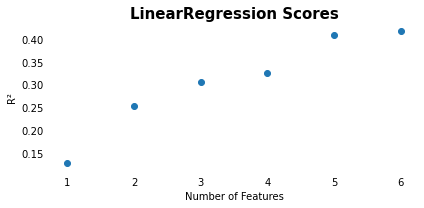

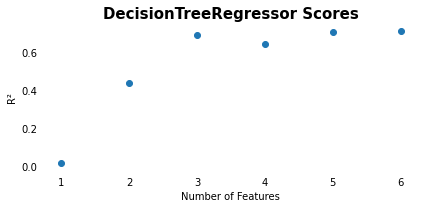

In [70]:
wrapper_methods(estimators_dict=estimators, method='rfe', 
                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

I would choose the four or five best features:

- `floor_area` 
- `latitude` 
- `longitude` 
- `bathroom`
- `views`

### Forward Feature Selection

LinearRegression 
----------
['floor_area'] 

['floor_area' 'longitude'] 

['floor_area' 'latitude' 'longitude'] 

['floor_area' 'views' 'latitude' 'longitude'] 

['floor_area' 'views' 'latitude' 'longitude' 'bathroom'] 

['floor_area' 'views' 'latitude' 'longitude' 'bedroom' 'bathroom'] 

[0.2582610340375323, 0.38715986345713627, 0.40115999069736796, 0.40996826963652055, 0.4177952752371136, 0.41780232516371885] 

DecisionTreeRegressor 
----------
['psr'] 

['psr' 'bedroom'] 

['psr' 'longitude' 'bedroom'] 

['floor_area' 'psr' 'longitude' 'bedroom'] 

['floor_area' 'psr' 'latitude' 'longitude' 'bedroom'] 

['floor_area' 'psr' 'latitude' 'longitude' 'bedroom' 'bathroom'] 

[0.2005905978226714, 0.29738687116303564, 0.31433457940828835, 0.49081257347854457, 0.7093972241648481, 0.7374671540772388] 



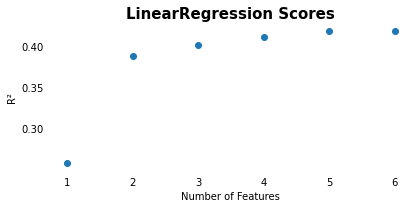

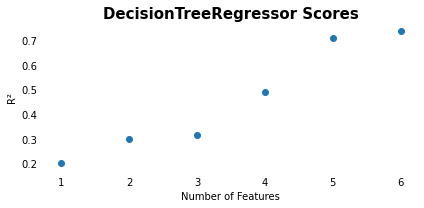

In [71]:
wrapper_methods(estimators_dict=estimators, method='sfs_forward', 
                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

I would choose the four or five best features:

- `floor_area` 
- `latitude` 
- `longitude` 
- `bedroom`
- `psr`

### Backward Feature Elimination

LinearRegression 
----------
['floor_area'] 

['floor_area' 'longitude'] 

['floor_area' 'latitude' 'longitude'] 

['floor_area' 'views' 'latitude' 'longitude'] 

['floor_area' 'views' 'latitude' 'longitude' 'bathroom'] 

['floor_area' 'views' 'latitude' 'longitude' 'bedroom' 'bathroom'] 

[0.2582610340375323, 0.38715986345713627, 0.40115999069736796, 0.40996826963652055, 0.4177952752371136, 0.41780232516371885] 

DecisionTreeRegressor 
----------
['floor_area'] 

['floor_area' 'longitude'] 

['floor_area' 'latitude' 'longitude'] 

['floor_area' 'latitude' 'longitude' 'bathroom'] 

['floor_area' 'psr' 'latitude' 'longitude' 'bathroom'] 

['floor_area' 'psr' 'latitude' 'longitude' 'bedroom' 'bathroom'] 

[0.17392130776833392, 0.4368690047555489, 0.7002720395074262, 0.7104656698916101, 0.7111292018453061, 0.7389903380434306] 



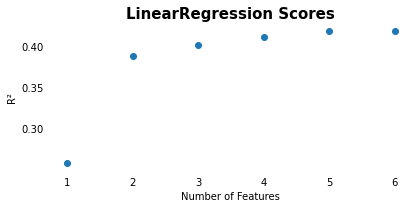

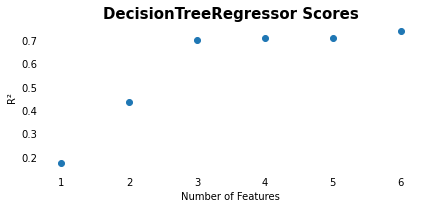

In [72]:
wrapper_methods(estimators_dict=estimators, method='sfs_backward', 
                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

I would choose the four or five best features:

- `floor_area` 
- `latitude` 
- `longitude` 
- `bedroom`
- `bathroom`

### Conclusions

I think we should choose those variables that are most repeated in the three methods so my decision would be the following:

- `floor_area` 
- `latitude` 
- `longitude` 
- `bedroom`
- `bathroom`

Also as I said earlier `psr` could be similar than place or location features.

It is important to note that we have made the wrapper methods without categorical data, so it could be categorical variables that acts as a proxy for any of the variables. 

## Conclusions

After the full analysis made I think tha the following variables are the best predictors in order to predict the houses prices:

- `floor_area` 
- `latitude` 
- `longitude` 
- `bedroom`
- `bathroom`
- `place`
- `type_house`
- `city_district` (not sure)

In [73]:
selected_variables = ['price', 
                      'floor_area', 
                      'bedroom', 
                      'bathroom', 
                      'place', 
                      'type_house', 
                      'longitude', 
                      'latitude', 
                      'city_district'] # , 'city_district'   code en lugar de place

In [74]:
sale_out[selected_variables].to_csv('data/selected_data.csv', sep=',', index=False)